# Milestone 2 Phase 2
- Muhammad Fadlil Ismail
- FTDS Batch 10

## 1. Introduction

### a. Objective
Milestones 2 ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

  1. Mampu memahami konsep Computer Vision/NLP.
  2. Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
  3. Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
  4. Mampu menganalisis dan menjelaskan layer yang dibuat.

### b. Tentang Dataset
Dataset bersumber dari :
https://www.kaggle.com/datasets/raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

This dataset contains images of 6 fruits and vegetables: apple, banana, bitter gourd, capsicum, orange, and tomato. The images of each fruit or vegetable are grouped into two categories: fresh and stale. The purpose behind the creation of this dataset is the development of a machine learning model to classify fruits and vegetables as fresh or stale. 

### c. Problem Statement
Membuat program untuk membantu supplier barang atau supermarket besar dalam memprediksi kualitas dari sayuran dan buah-buahan yang dijualnya.


Sebelum dilakukan running terhadap cell di bawah ini pastikan anda telah:
1. Mengganti runtime ke GPU
2. Meng-upload file kaggle.json ke Google Colab

## 2. Import Library

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

## 3. Load Data
Karena ukuran dataset yang besar (mencapai 2 GB), maka akan dilakukan pengunduhan secara langsung dari kaggle menggunakan command di bawah ini (command di bawah ini hanya dapat berjalan pada Google Colaboratory).

In [2]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [3]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [4]:
!kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

100% 1.41G/1.41G [00:22<00:00, 90.8MB/s]
100% 1.41G/1.41G [00:22<00:00, 66.5MB/s]


In [5]:
!unzip -q /content/fresh-and-stale-images-of-fruits-and-vegetables.zip -d images #images adalah nama folder

Dataset sudah berhasil di-download dan disimpan pada folder images. Cek direktori pada folder images.

In [2]:
os.listdir('/content/images')

['fresh_tomato',
 'stale_tomato',
 'stale_apple',
 'stale_banana',
 'ImageLabels.txt',
 'fresh_bitter_gourd',
 'stale_orange',
 'fresh_banana',
 'fresh_orange',
 'stale_bitter_gourd',
 'fresh_capsicum',
 'fresh_apple',
 'stale_capsicum']

Set main path pada folder images dan buat path untuk tiap-tiap kelas dataset

In [3]:
dir_class = []
main_path = '/content/images'
for label in os.listdir('/content/images'):
  a = os.path.join(main_path, label)
  if a=='/content/images/ImageLabels.txt':
    continue
  else:
    dir_class.append(a)
label_unique = [i for i in os.listdir('/content/images') if i != 'ImageLabels.txt']

In [4]:
dir_label = list(zip(dir_class, label_unique))

Ambil path dan label untuk tiap-tiap gambar, simpan hasilnya ke dalam dataframe

In [5]:
alamat = []
label = []
for dir, lab in dir_label:
  for path in os.listdir(dir):
    alamat.append(dir + '/' +path)
    label.append(lab)


Berikut dataframe yang berisi path dan label dari tiap-tiap image :

In [6]:
df = pd.DataFrame({'image':alamat, 'label':label})
df.head()

image         label
0  /content/images/fresh_tomato/DSCN4114.jpg_0_88...  fresh_tomato
1  /content/images/fresh_tomato/DSCN4142.jpg_0_45...  fresh_tomato
2  /content/images/fresh_tomato/IMG_20200725_0954...  fresh_tomato
3  /content/images/fresh_tomato/DSCN4142.jpg_0_92...  fresh_tomato
4  /content/images/fresh_tomato/tomato1_8.jpg_0_4...  fresh_tomato

## 3. Exploratory Data Analysis

### a. Hitung jumlah gambar untuk tiap-tiap kelas

In [7]:
df.label.value_counts()

stale_apple           2342
fresh_apple           1693
stale_orange          1595
fresh_banana          1581
stale_banana          1467
fresh_orange          1466
fresh_capsicum         990
stale_tomato           982
fresh_tomato           981
stale_capsicum         901
stale_bitter_gourd     357
fresh_bitter_gourd     327
Name: label, dtype: int64

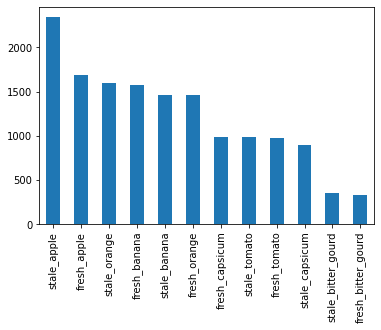

In [8]:
df.label.value_counts().plot(kind='bar')

Kelas paling banyak adalah stale_apple (sebanyak 2342 gambar) adapun kelas paling sedikit adalah fresh_bitter_gourd (sebanyak 327 gambar).

### b. Tampilkan gambar untuk masing-masing kelas
Berikut adalah contoh gambar (sejumlah lima) dari tiap-tiap kelas gambar :

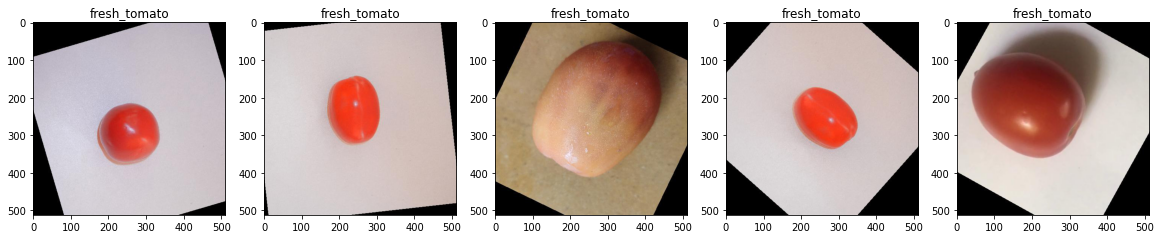

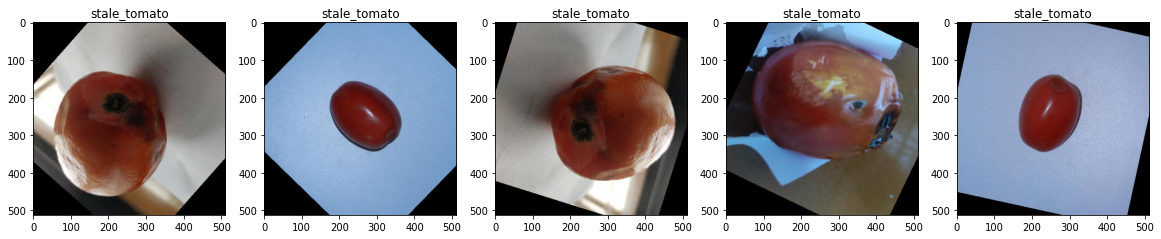

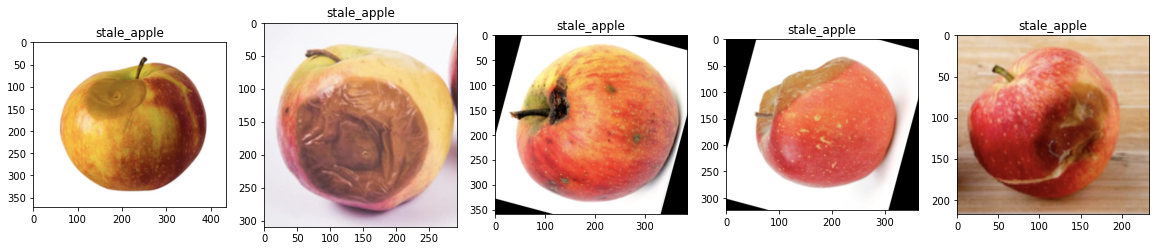

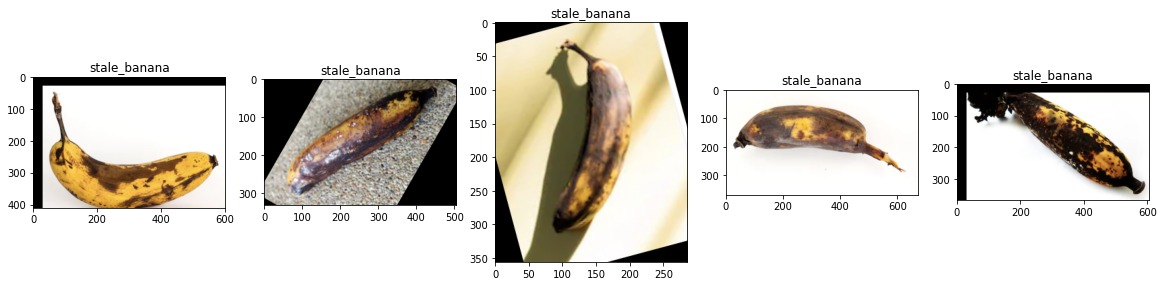

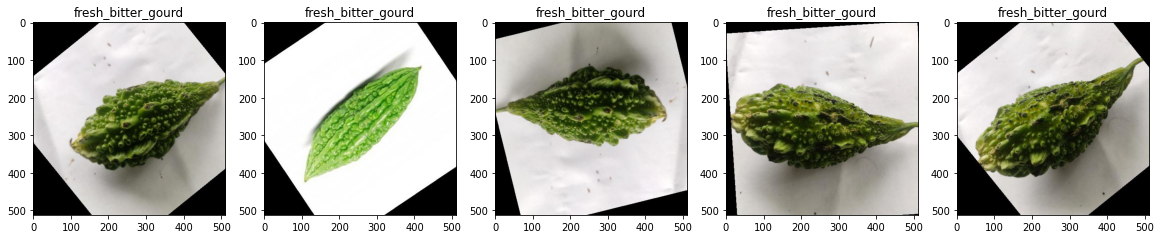

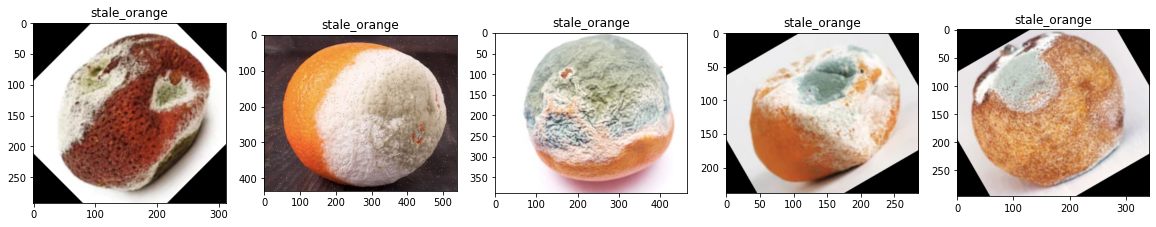

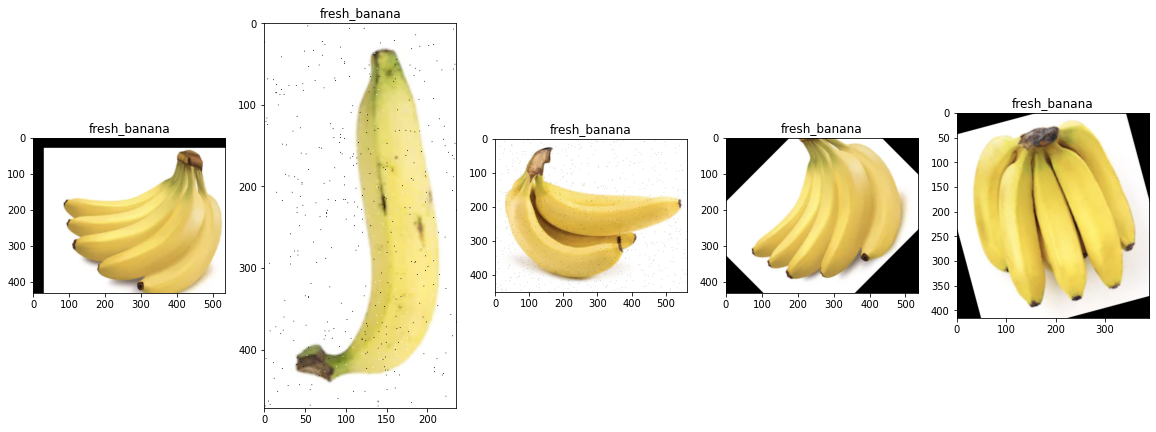

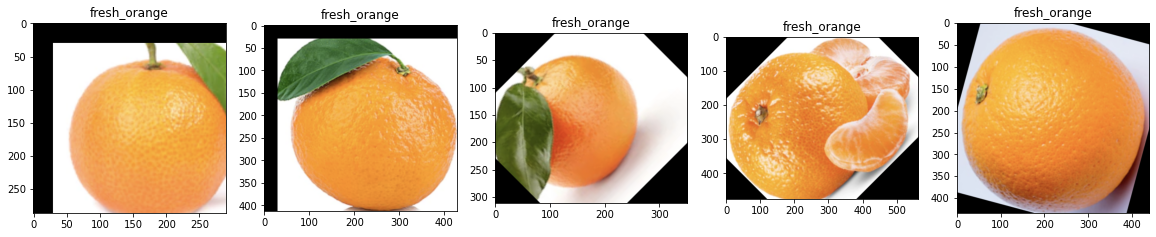

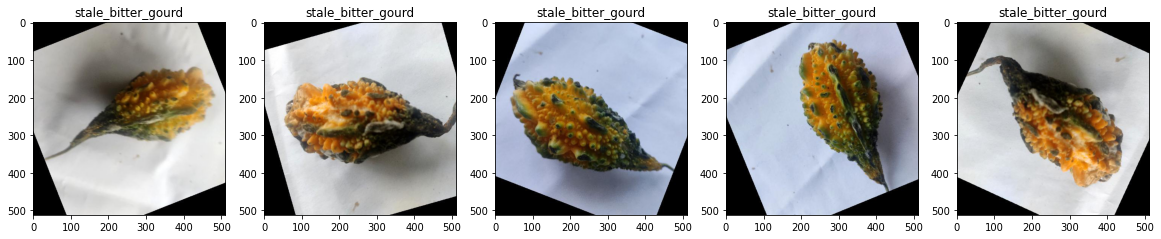

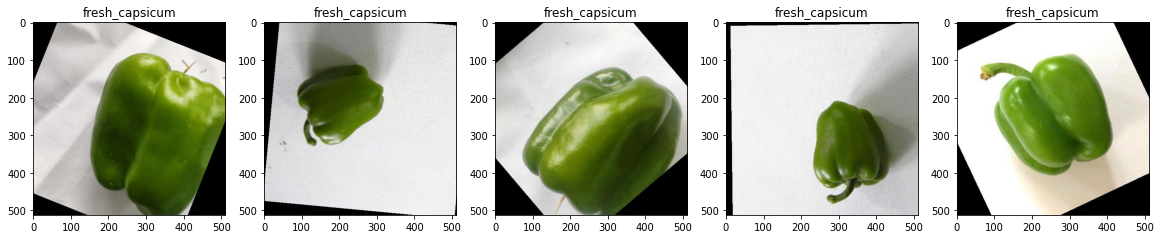

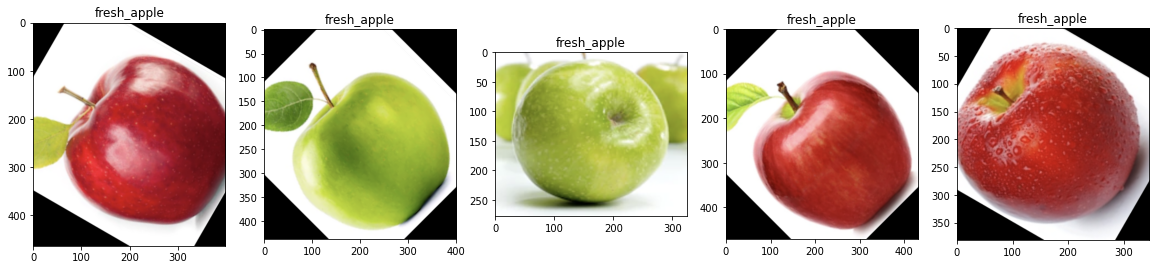

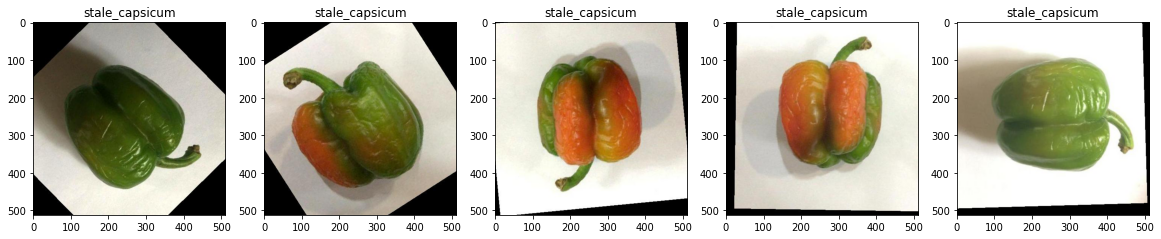

In [9]:
for label in df.label.unique().tolist():
  fig, ax = plt.subplots(ncols=5, figsize=(20,10))
  for i, path in enumerate(df[df.label==label].image.head()):
    gambar = plt.imread(path)
    ax[i].set_title(label)
    ax[i].imshow(gambar)
  plt.show()

Dari gambar di atas terlihat bahwa beberapa gambar memiliki dimensi yang berbeda dibanding gambar lainnya.

### c. Hitung rentang dimensi gambar
Pada bagian ini akan dihitung dimensi dari tiap-tiap gambar untuk diketahui rentang panjang dan lebar pixel gambar pada dataset.

In [10]:
h = []
w = []
for path in df.image:
  gambar = plt.imread(path)
  height = gambar.shape[0]
  width = gambar.shape[1]
  h.append(height)
  w.append(width)

In [11]:
minh = min(h)
maxh = max(h)
meanh = round(np.mean(h))

minw = min(w)
maxw = max(w)
meanw = round(np.mean(w))

print(f'Rata rata dimensi gambar adalah ({meanh}, {meanw}, 3).')
print(f'Rentang tinggi gambar adalah {minh} sampai {maxh}.')
print(f'Rentang lebar gambar adalah {minw} sampai {maxw}.')

Rata rata dimensi gambar adalah (401, 442, 3).
Rentang tinggi gambar adalah 116 sampai 518.
Rentang lebar gambar adalah 144 sampai 862.


Didapat hasil sebagai berikut:

1. Rata rata dimensi gambar adalah (401, 442, 3).
2. Rentang tinggi gambar adalah 116 sampai 518.
3. Rentang lebar gambar adalah 144 sampai 862.

Berikut distribusi dimensi (tinggi dan lebar) gambar:

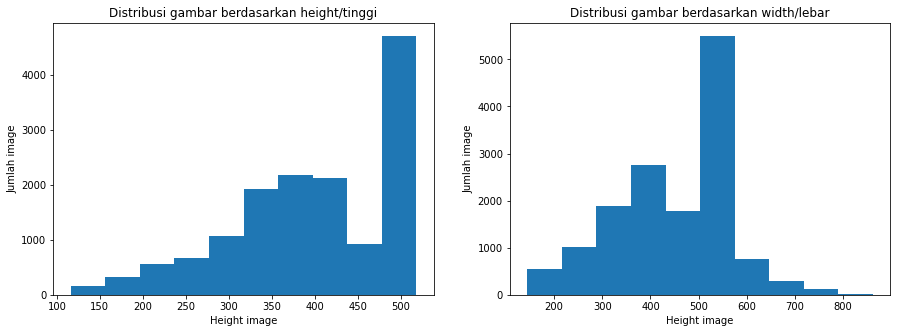

In [12]:
fig, ax = plt.subplots(ncols=2,figsize=(15,5))
ax[0].hist(np.array(h))
ax[0].set_title('Distribusi gambar berdasarkan height/tinggi')
ax[0].set_xlabel('Height image')
ax[0].set_ylabel('Jumlah image')
ax[1].hist(np.array(w))
ax[1].set_title('Distribusi gambar berdasarkan width/lebar')
ax[1].set_xlabel('Height image')
ax[1].set_ylabel('Jumlah image')
plt.show()

Didapatkan bahwa mayoritas data memiliki tinggi sekitar 500 pixel dan lebar sekitar 500-550 pixel.

## 4. Data Preprocessing

### a. Split data train, data validation dan data test
Dataset akan di split menjadi data train, data validation dan data test dengan komposisi sebagai berikut :

In [13]:
df_train, df_test= train_test_split(df, test_size=0.15, stratify=df.label, random_state=69)
df_train, df_val= train_test_split(df_train, test_size=0.1, stratify=df_train.label, random_state=69)

Cek dimensi dari data train, data val dan data test :

In [14]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(11231, 2)
(1248, 2)
(2203, 2)


Dimensi data train, data val dan data test telah sesuai.

### b. Augmentasi Data
Augmentasi data yang dilakukan pada data train hanyalah rescale saja. Karena dari EDA dan penjelasan mengenai dataset di kaggle, diketahui bahwa sebagian gambar pada dataset ini adalah gambar hasil augmentasi keras. Adapun penggunaan brightness range malah menurunkan performa dari model ketika diujicoba menggunakan data inference.

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Nilai img_height dan img_width di-set sama dengan 128, agar pemrosesan gambar berjalan tidak terlalu lama. Untuk nilai BATCH dan SEED di-set secara random

In [16]:
img_height= 128
img_width= 128
SEED = 1
BATCH =32

np.random.seed(42)
tf.random.set_seed(42)

### c. Buat Tensorflow Pipeline

Dibuat tensorflow dataset dengan menggunakan method flow_from_dataframe, hal ini dikarenakan path dan kelas dari tiap-tiap gambar di dataset tersimpan dalam dataframe.

In [17]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle = False,
    seed=SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle = False,
    seed=SEED)

Found 11231 validated image filenames belonging to 12 classes.
Found 1248 validated image filenames belonging to 12 classes.
Found 2203 validated image filenames belonging to 12 classes.


Cek kelas beserta penomorannya untuk tiap-tiap tensorflow dataset (train, val, test):

In [18]:
ds_train.class_indices

{'fresh_apple': 0,
 'fresh_banana': 1,
 'fresh_bitter_gourd': 2,
 'fresh_capsicum': 3,
 'fresh_orange': 4,
 'fresh_tomato': 5,
 'stale_apple': 6,
 'stale_banana': 7,
 'stale_bitter_gourd': 8,
 'stale_capsicum': 9,
 'stale_orange': 10,
 'stale_tomato': 11}

In [19]:
ds_val.class_indices

{'fresh_apple': 0,
 'fresh_banana': 1,
 'fresh_bitter_gourd': 2,
 'fresh_capsicum': 3,
 'fresh_orange': 4,
 'fresh_tomato': 5,
 'stale_apple': 6,
 'stale_banana': 7,
 'stale_bitter_gourd': 8,
 'stale_capsicum': 9,
 'stale_orange': 10,
 'stale_tomato': 11}

In [20]:
ds_test.class_indices

{'fresh_apple': 0,
 'fresh_banana': 1,
 'fresh_bitter_gourd': 2,
 'fresh_capsicum': 3,
 'fresh_orange': 4,
 'fresh_tomato': 5,
 'stale_apple': 6,
 'stale_banana': 7,
 'stale_bitter_gourd': 8,
 'stale_capsicum': 9,
 'stale_orange': 10,
 'stale_tomato': 11}

Terlihat penomoran untuk tiap-tiap kelas pada data train, val, dan test sudah konsisten.

## 5. Model Definition
Dibuat model baseline dengan jumlah layer konvolusi 2 buah dan dense layer 2 buah (dense layer terakhir sebagai output layer). Dengan spesifikasi lebih detail sebagai berikut :

In [21]:
input= [img_height,img_width,3]

model= Sequential()

#Conv 1
model.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))
#Conv 2
model.add(Conv2D(filters=32,kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
#Dense 1
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
#Dense 2
model.add(Dense(units=12, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

Model akan di-compile dengan optimizer 'adam' dengan loss categorical crossentropy (karena dataset memiliki kelas lebih dari 2) dengan metriks accuracy.

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])

Callbacks yang digunakan adalah:

- EarlyStopping yang akan menghentikan training apabila vall_loss tidak kunjung turun selama 7 epoch
- ModelCheckpoint yang akan menyimpan model pada epoch dengan vall_loss paling kecil
- ReduceLROnPlateau yang berfungsi untuk menurunkan learning rate apabila val_loss tidak turun selama satu epoch. 

Nilai patience untuk ReduceLROnPlateau harus lebih kecil daripada patience EarlyStopping, hal ini dilakukan agar memberikan kesempatan pada model untuk mengubah learning rate sebelum menghentikan training, apabila nilai patience dari ReduceLROnplateau lebih besar maka model tidak memiliki kesempatan untuk mengubah learning rate apabila terjadi kenaikan val_loss. 

In [24]:
callbacks= [
    EarlyStopping(monitor= 'val_loss', mode= 'min', patience= 7, verbose=1),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=1, min_lr=0.0001)]

## 6. Model Training
Model training untuk baseline model dilakukan sebanyak 10 epoch.

In [25]:
epochs=10
history= model.fit(ds_train, batch_size= BATCH, epochs=epochs, 
                          validation_data= ds_val, callbacks= callbacks, verbose=1)

Epoch 1/10
351/351 [==============================] - 49s 134ms/step - loss: 1.4816 - accuracy: 0.4819 - val_loss: 0.6986 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 2/10
351/351 [==============================] - 46s 132ms/step - loss: 0.6841 - accuracy: 0.7496 - val_loss: 0.4482 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 3/10
351/351 [==============================] - 47s 134ms/step - loss: 0.4964 - accuracy: 0.8146 - val_loss: 0.3028 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 4/10
351/351 [==============================] - 47s 133ms/step - loss: 0.4337 - accuracy: 0.8399 - val_loss: 0.3012 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 5/10
351/351 [==============================] - 46s 132ms/step - loss: 0.3789 - accuracy: 0.8573 - val_loss: 0.2650 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 6/10
351/351 [==============================] - 47s 133ms/step - loss: 0.3485 - accuracy: 0.8679 - val_loss: 0.2354 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 7/10
351/351 [==============================] 

## 7. Model Evaluation
Didapatkan grafik loss dan accuracy pada setaip epoch untuk data train dan data val sebagai berikut :

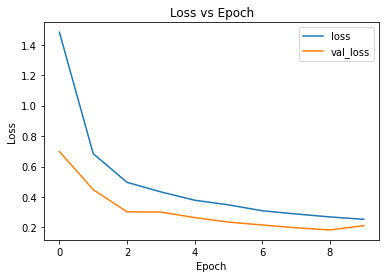

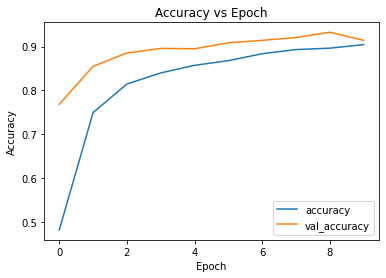

In [41]:
metrics = pd.DataFrame(history.history)
metrics[['loss', 'val_loss']].plot(title='Loss vs Epoch', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(title='Accuracy vs Epoch', xlabel='Epoch', ylabel='Accuracy')
plt.show()

Dari grafik terlihat bahwa model hasil training tidak overvitting dikarenakan pada epoch terakhir nilai loss dan accuracy antara data train dan data val terlihat berhimpitan. Pada epoch terakhir (epoch 10) didapat nilai loss dan accuracy untuk data train dan data val sebagai berikut :

```
train loss: 0.2535   train accuracy: 0.9045  
val loss  : 0.2124   val accuracy  : 0.9143
```

Selanjutnya akan dilakukan prediksi terhadap data test menggunakan model yang telah di-train, sebelumnya dibuat dictionary terlebih dahulu untuk memetakan hasil prediksi model terhadap data test:

In [27]:
dict_class = {}
for key, val in ds_train.class_indices.items():
  dict_class[val] = key
dict_class

{0: 'fresh_apple',
 1: 'fresh_banana',
 2: 'fresh_bitter_gourd',
 3: 'fresh_capsicum',
 4: 'fresh_orange',
 5: 'fresh_tomato',
 6: 'stale_apple',
 7: 'stale_banana',
 8: 'stale_bitter_gourd',
 9: 'stale_capsicum',
 10: 'stale_orange',
 11: 'stale_tomato'}

In [28]:
y_test = df_test.label
y_pred_test = model.predict(ds_test)
y_pred_test = np.argmax(y_pred_test, axis = 1)
y_pred_test = pd.Series(y_pred_test).map(dict_class)

Berikut adalah classification report untuk hasil prediksi data test :

In [29]:
print(classification_report(y_test, y_pred_test))

                    precision    recall  f1-score   support

       fresh_apple       0.92      0.94      0.93       254
      fresh_banana       0.98      0.97      0.97       237
fresh_bitter_gourd       1.00      1.00      1.00        49
    fresh_capsicum       1.00      0.93      0.96       149
      fresh_orange       0.95      0.91      0.93       220
      fresh_tomato       0.83      0.98      0.90       147
       stale_apple       0.89      0.91      0.90       352
      stale_banana       0.96      0.97      0.96       220
stale_bitter_gourd       1.00      0.87      0.93        54
    stale_capsicum       0.92      1.00      0.96       135
      stale_orange       0.88      0.87      0.88       239
      stale_tomato       0.97      0.80      0.88       147

          accuracy                           0.93      2203
         macro avg       0.94      0.93      0.93      2203
      weighted avg       0.93      0.93      0.93      2203



Insight yang dapat diambil dari classification report di atas:

1. Nilai accuracy terhadap data test sebesar 0.93 yang artinya 93% gambar pada data test dapat diprediksi dengan benar oleh model. 

2. Nilai f1_score tertinggi sebesar 1 untuk kelas fresh_bitter_gourd adapun nilai f1_score terendah sebsar 0.88 untuk kelas stale_orange dan stale_tomato. Artinya model paling baik performanya jika digunakan untuk melakukan prediksi terhadap kelas fresh_bitter_gourd, akan tetapi paling rendah performanya jika digunakan untuk memprediksi kelas stale_orange dan stale_tomato. 

3. Model dengan akurasi 93% bisa dikatakan kurang baik karena terdapat model CNN yang memiliki akurasi 100% untuk dataset ini, oleh karena itu dilakukan Model Improvement pada section selanjutnya.

### Model Improvement
Dilakukan model improvement dengan melakukan beberapa perubahan, antara lain:
1. Menambah jumlah layer konvolusi (dari 2 menjadi 3).
2. Menambah kan BatchNormalization untuk tiap-tiap layer.
3. Mengurangi jumlah dropout dari 0.2 menjadi 0.1.
Berikut rincian arsitektur model hasil improvisasi:

In [30]:
model2= Sequential()

#Conv 1
model2.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input)) 
model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(BatchNormalization()) 
model2.add(Dropout(0.1))
#Conv 2
model2.add(Conv2D(filters=32,kernel_size=3, activation= 'relu'))
model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(BatchNormalization()) 
model2.add(Dropout(0.1))
#Conv 3
model2.add(Conv2D(filters=64,kernel_size=3, activation= 'relu'))
model2.add(MaxPooling2D(pool_size=2, strides=2))
model2.add(BatchNormalization()) 
model2.add(Dropout(0.1))
model2.add(Flatten())
#Dense 1
model2.add(Dense(units=128, activation='relu'))
model2.add(BatchNormalization()) 
model2.add(Dropout(0.1))
#Dense 2
model2.add(Dense(units=12, activation='softmax'))

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 16)       64        
 ormalization)                                                   
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)      

Compile yang dilakukan sama seperti model sebelumnya :

In [32]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])

Callbacks sama seperti model sebelumnya, hanya saja untuk ReduceLROnPlateau minimum learning rate nya diubah menjadi 1x10^-5 dari sebelumnya 1x10^-4.

In [33]:
callbacks2= [
    EarlyStopping(monitor= 'val_loss', mode= 'min', patience= 7, verbose=1),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001)]

Dilakukan training dengan jumlah epoch sebesar 20:

In [34]:
history2= model2.fit(ds_train, batch_size= BATCH, epochs=20, 
                          validation_data= ds_val, callbacks= callbacks2, verbose=1)

Epoch 1/20
351/351 [==============================] - 48s 135ms/step - loss: 0.5968 - accuracy: 0.7999 - val_loss: 2.3964 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 2/20
351/351 [==============================] - 47s 134ms/step - loss: 0.2255 - accuracy: 0.9259 - val_loss: 0.6751 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 3/20
351/351 [==============================] - 47s 134ms/step - loss: 0.1523 - accuracy: 0.9494 - val_loss: 0.3146 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 4/20
351/351 [==============================] - 47s 134ms/step - loss: 0.1097 - accuracy: 0.9653 - val_loss: 0.2149 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 5/20
351/351 [==============================] - 47s 133ms/step - loss: 0.0946 - accuracy: 0.9680 - val_loss: 0.3860 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 6/20
351/351 [==============================] - 47s 134ms/step - loss: 0.0475 - accuracy: 0.9869 - val_loss: 0.1161 - val_accuracy: 0.9575 - lr: 5.0000e-04
Epoch 7/20
351/351 [============================

Berikut grafik loss dan accuracy pada tiap-tiap epoch untuk data train dan data val:

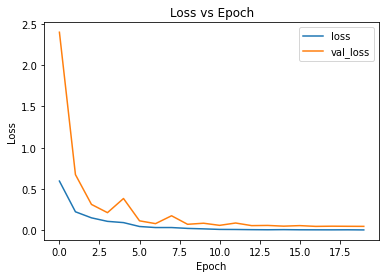

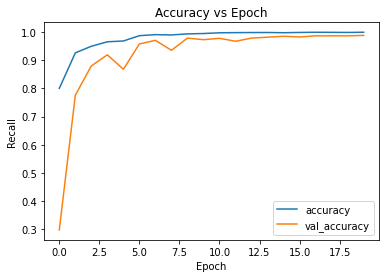

In [35]:
metrics2 = pd.DataFrame(history2.history)
metrics2[['loss', 'val_loss']].plot(title='Loss vs Epoch', xlabel='Epoch', ylabel='Loss')
metrics2[['accuracy', 'val_accuracy']].plot(title='Accuracy vs Epoch', xlabel='Epoch', ylabel='Recall')
plt.show()

Dari grafik terlihat bahwa model hasil training tidak overvitting dikarenakan pada epoch terakhir nilai loss dan accuracy antara data train dan data val terlihat berhimpitan. Pada epoch terakhir (epoch 20) didapat nilai loss dan accuracy untuk data train dan data val sebagai berikut :

```
train loss: 0.0062   train accuracy: 0.9991  
val loss  : 0.0491   val accuracy  : 0.9880
```

Model ini dapat dikatakan lebih baik dibandingkan model sebelumnya, hal ini dikarenakan model hasil improvement pada epoch ke 10 (model sebelumnya di-train 10 epoch) memiliki nilai loss yang lebih kecil dan nilai accuracy yang  lebih tinggi berikut perbandingannya:

```
Model awal:
train loss: 0.2535   train accuracy: 0.9045  
val loss  : 0.2124   val accuracy  : 0.9143
Model final:
train loss: 0.0190   train accuracy: 0.9946  
val loss  : 0.0871   val accuracy  : 0.9728
```

Selanjutnya akan dilakukan prediksi terhadap data test menggunakan model yang telah di-train:

In [36]:
y_pred_test2 = model2.predict(ds_test)
y_pred_test2 = np.argmax(y_pred_test2, axis = 1)
y_pred_test2 = pd.Series(y_pred_test2).map(dict_class)

Berikut classification report untuk hasil prediksi model hasil improvement terhadap data test :

In [37]:
print(classification_report(y_test, y_pred_test2))

                    precision    recall  f1-score   support

       fresh_apple       1.00      0.99      0.99       254
      fresh_banana       0.99      1.00      1.00       237
fresh_bitter_gourd       1.00      1.00      1.00        49
    fresh_capsicum       1.00      1.00      1.00       149
      fresh_orange       1.00      0.97      0.99       220
      fresh_tomato       0.95      1.00      0.98       147
       stale_apple       1.00      0.98      0.99       352
      stale_banana       1.00      0.99      1.00       220
stale_bitter_gourd       1.00      1.00      1.00        54
    stale_capsicum       0.99      1.00      1.00       135
      stale_orange       0.95      1.00      0.97       239
      stale_tomato       1.00      0.95      0.98       147

          accuracy                           0.99      2203
         macro avg       0.99      0.99      0.99      2203
      weighted avg       0.99      0.99      0.99      2203



Dari classification report di atas dapat diambil insight:

1. Nilai accuracy terhadap data test sebesar 0.99 yang artinya 99% gambar pada data test dapat diprediksi dengan benar oleh model. 

2. Nilai f1_score tertinggi sebesar 1 untuk kelas fresh_banana, fresh_bitter_gourd, fresh_capsicum, stale_banana, stale_bitter_gourd dan stale_capsicum adapun nilai f1_score terendah sebsar 0.97 untuk kelas stale_orange. Artinya model paling baik performanya jika digunakan untuk melakukan prediksi terhadap kelas fresh_banana, fresh_bitter_gourd, fresh_capsicum, stale_banana, stale_bitter_gourd dan stale_capsicum, akan tetapi paling rendah performanya jika digunakan untuk memprediksi kelas stale_orange. 

3. Model dengan akurasi 99% bisa dikatakan cukup baik karena hanya selisih satu persen terhadap model CNN terbaik untuk dataset ini.

## 8. Model Saving
Model hasil improvement disimpan untuk di-deploy ke heroku:


In [40]:
model2.save('fruit_veg_model.h5')

## 9. Model Inference
Diambil 6 buah gambar dari google, dengan penjelasan sebagai berikut:
1. Gambar 1: apel segar dengan background berwarna putih
2. Gambar 2: apel busuk dengan background berwarna putih
3. Gambar 3: apel segar berada di dalam wadah kaca
4. Gambar 4: apel segar berada di pohon, background dedaunan
5. Gambar 5: apel segar dengan background berwarna hitam
6. Gambar 6: pisang segar dengan background berwarna putih

Saving apel.jpg to apel.jpg
Saving apel_busuk.jpg to apel_busuk.jpg
Saving apel2.jpg to apel2.jpg
Saving apel-malang-anna_buah.jpg to apel-malang-anna_buah.jpg
Saving paris-city-portrait-tokyo-japan-tokyo-japan-wallpaper-preview.jpg to paris-city-portrait-tokyo-japan-tokyo-japan-wallpaper-preview.jpg
Saving pisang.jpg to pisang.jpg


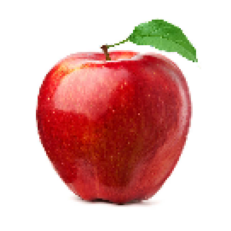

Model 1 result : fresh_apple
Model 2 result : fresh_apple


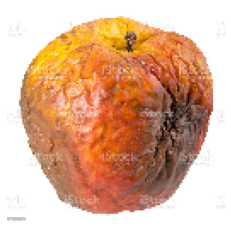

Model 1 result : stale_apple
Model 2 result : stale_apple


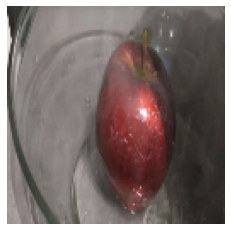

Model 1 result : fresh_tomato
Model 2 result : fresh_tomato


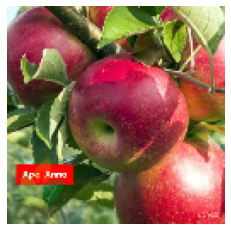

Model 1 result : stale_banana
Model 2 result : stale_banana


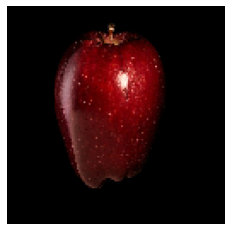

Model 1 result : fresh_tomato
Model 2 result : fresh_tomato


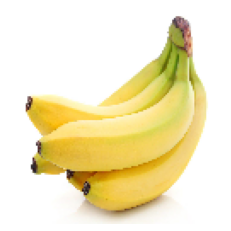

Model 1 result : fresh_banana
Model 2 result : fresh_banana


In [39]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(128,128))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img)
  classes1 = np.argmax(model2.predict(np.array([x])/255))
  classes2 = np.argmax(model2.predict(np.array([x])/255))
  print("Model 1 result :", dict_class[classes1])
  print("Model 2 result :", dict_class[classes2]) 


Setelah dilakukan prediksi menggunakan model1 dan model2, diketahui bahwa hasil prediksi dari kedua model tersebut adalah sama. Berikut hasil prediksi beserta kunci jawabannya:
```
1. Prediksi : fresh_apple (model1 dan model2)
   Jawaban  : fresh_apple
2. Prediksi : stale_apple (model1 dan model2)
   Jawaban  : stale_apple
3. Prediksi : fresh_tomato (model1 dan model2)
   Jawaban  : fresh_apple
4. Prediksi : stale_banana (model1 dan model2)
   Jawaban  : fresh_apple
5. Prediksi : fresh_tomato (model1 dan model2)
   Jawaban  : fresh_apple
6. Prediksi : fresh_banana (model1 dan model2)
   Jawaban  : fresh_banana
```
Model salah dalam menjawab gambar nomor 3,4 dan 5 yang mana jawaban yang benar untuk ketiga gambar tersebut adalah fresh_apple. Ketiga gambar tersebut memiliki background yang tidak berwarna putih, artinya kemampuan model dalam melakukan prediksi gambar buah/sayur tergantung dari background foto buah/sayur.

## 10. Kesimpulan
Kesimpulan yang dapat diambil dari pengerjaan tugas ini adalah:
1. Dataset berupa gambar dari 6 jenis buah dan sayuran yang masing masing dibagi menjadi 2 berdasarkan kualitasnya (stale dan fresh). Sehingga terdapat 12 kelas gambar pada dataset ini, berikut rinciannya beserta jumlahnya untuk tiap-tiap kelas:
```
stale_apple           2342
fresh_apple           1693
stale_orange          1595
fresh_banana          1581
stale_banana          1467
fresh_orange          1466
fresh_capsicum         990
stale_tomato           982
fresh_tomato           981
stale_capsicum         901
stale_bitter_gourd     357
fresh_bitter_gourd     327
```
2. Gambar pada dataset memiliki dimensi yang berbeda-beda, adapun rata-rata dimensinya adalah (tinggixlebar) : 401x442.

3. Dari penjelasan author dari dataset ini di kaggle, diketahui bahwa beberapa gambar pada dataset adalah gambar hasil augmentasi keras, sehingga pada preprocessing hanya dilakukan rescale saja pada data train.

4. Model CNN baseline dengan 2 layer konvolusi dan 2 dense layer setelah di-train mendapatkan akurasi 0.93 terhadap data test. Setelah dilakukan improvement dengan menambah 1 layer konvolusi, menambah batch normalization pada tiap layer dan mengurangi nilai dropout pada tiap layer didapatkan model dengan akurasi terhadap data test sebesar 0.99. Model CNN terbaik untuk dataset ini memiliki akurasi sebesar 1 atau 100%.

5. Walaupun model memiliki nilai accuracy mencapai 0.99 atau 99% terhadap data test, model ini masih memiliki kekurangan. Pada saat model dicoba untuk memprediksi buah apel dengan background yang tidak berwarna putih, model salah dalam memprediksi gambar buah apel tersebut. Hal ini terjadi dikarenakan model dilatih dengan background yang kebanyakan berwarna putih, sehingga apabila model digunakan untuk memprediksi foto buah/sayur dengan warna background selain putih, kemungkinan model akan salah dalam memprediksi gambar. 

6. Untuk meningkatkan performa model, maka jumlah gambar pada dataset ini harus ditambah, terutama dengan foto buah/sayur dengan berbagai macam warna background (selain putih) sehingga kemampuan model dalam melakukan prediksi gambar buah/sayur tidak bergantung dari warna background foto.
